# 1.3「전이학습」을 통한 적은 양의 데이터 분류

- pre_train된 VGG모델을 통해 샘픔 데이터(개미, 벌) 분류 진행


# 학습목표

1. 이미지 데이터로 데이터셋 제작
2. 데이터셋으로 데이터 로더 제작
3. 학습된 모델의 출력층을 원하는 형태로 변경
4. 출력층의 결합 파라미터만 학습하여 전이학습 구현



# 사전준비

1. make_folders_and_data_downloads.ipynb 를 통해 데이터 다운로드
2. 시간 확인을 위해 tqdm 설치
    
    conda install -c conda-forge tqdm



In [1]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [2]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSetを作成

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    이미지 전처리 클래스, 훈련/추론 시의 동작이 다름
    이미지 크기 리사이즈 및 색상 표준화
    훈련 시 RandomResizedCrop 및 RandomHorizontalFlip을 통한 데이터 augmentation 진행


    Attributes
    ----------
    resize : int
        크기 변경 전의 이미지 크기
    mean : (R, G, B)
        각 생상 채널의 평균값
    std : (R, G, B)
        각 색상 채널의 표준편차
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # 데이터 확장
                transforms.RandomHorizontalFlip(),  # 데이터 확장
                transforms.ToTensor(),  # 텐서 변환
                transforms.Normalize(mean, std)  # 색상 표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # 리사이즈
                transforms.CenterCrop(resize),  # 중앙 부분을 resize×resize로 크롭
                transforms.ToTensor(),  # 텐서 변환
                transforms.Normalize(mean, std)  # 표준화
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 설정
        """
        return self.data_transform[phase](img)


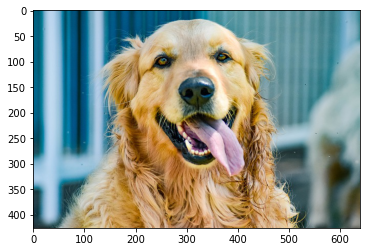

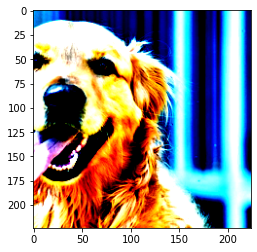

In [4]:
# 훈련 시 이미지 전처리 동작 확인
# 실행할 때마다 처리 결과 이미지가 변경 됨을 확인

# 1. 이미지 로드
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [높이][너비][RGB]

# 2. 원본 이미지 표시
plt.imshow(img)
plt.show()

# 3. 이미지 전처리, 처리된 이미지 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (색상、높이、너비)를 (높이、너비、색상)으로 변경 및 0-1로 값 변환
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [5]:
# 샘플 데이터(개미, 벌)이 담긴 이미지 파일을 경로 리스트로 작성


def make_datapath_list(phase="train"):
    """
    데이터 경로를 저장한 리스트 작성

    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터 지정

    Returns
    -------
    path_list : list
        데이터 경로를 지정한 리스트 작성
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # 경로 리스트

    # glob 함수를 이용하여 하위 디렉토리 경로 로드
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 실행
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list


./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [6]:
# 개미와 벌 이미지 Dataset 제작


class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 화상의 Dataset클래스. PyTorch의 Dataset클래스 상속

    Attributes
    ----------
    file_list : 리스트
        이미지 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'val'
        train, val 분류
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로 리스트
        self.transform = transform  # 전처리 클래스의 인스턴스
        self.phase = phase  # train or val 지정

    def __len__(self):
        '''이미지 개수 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 이미지의 Tensor데이터와 라벨 추출
        '''

        # index의 이미지 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][너비][RGB]

        # 이미지 전처리 실시
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 이미지 라벨을 파일 이름에서 추출
        # ./data/hymenoptera_data/train\ants\0013035.jpg
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # 라벨을 숫자(0, 1)로 변경
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 실행
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


# DataLoader 작성

In [7]:
# 미니 배치 사이즈 크기 조정
batch_size = 32

# DataLoader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# dict 타입으로 저장
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # iterator 타입으로 변환
inputs, labels = next(batch_iterator)  # 첫 번째 요소 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


# 네트워크 모델 작성

In [8]:
# 학습된 VGG-16 모델 로드
# VGG-16 모델의 인스턴스 생성
use_pretrained = True  # 학습된 파라미터 사용
vgg16_net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌인 두 개로 변경
vgg16_net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드 설정
vgg16_net.train()

print('네트워크 설정 완료：학습된 가중치를 읽어들여 훈련 모드 설정 완료')


네트워크 설정 완료：학습된 가중치를 읽어들여 훈련 모드 설정 완료


# 손실함수 설정

In [9]:
# 손실함수 설정
criterion = nn.CrossEntropyLoss()

# 최적화 기법 설정

In [10]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 리스트에 저장
params_to_update = []

# 학습시킬 파라미터명
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 외에는 경사를 계산하지 않고 변하지 않도록 설정
for name, param in vgg16_net.named_parameters():
    print(name)
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_update의 내용 확인
print("-----------")
print(params_to_update)


features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.weight
classifier.6.bias
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0133, -0.0051, -0.0067,  ...,  0.0068, -0.0040,  0.0070],
        [ 0.0063, -0.0014,  0.0149,  ..., -0.0018, -0.0116, -0.0079]],
       requires_grad=True), Parameter containing:
tensor([-0.0020, -0.0065], requires_grad=True)]


In [11]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


# 학습 및 검증 실시

In [12]:
# 학습 모델 함수 설정


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epoch 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 훈련 모드로 설정
            else:
                net.eval()   # 평가 모드로 설정

            epoch_loss = 0.0  # epoch별 로스 합
            epoch_corrects = 0  # epoch 정답 카운트

            # 학습하지 않을 시 검증 성능을 확인하기 위해、epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더를 통해 미니 배치별 input, 라벨 추출
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizer
                optimizer.zero_grad()

                # forward(순전파) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실 계산
                    _, preds = torch.max(outputs, 1)  # 라벨 예측
                    
                    # 훈련시 backward(역전파) 계산
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 반복 결과 계산
                    # loss 합계 계산
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 정답 수 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch당 loss와 정답률 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [13]:
# 학습 및 검증
num_epochs=2
train_model(vgg16_net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  5.00s/it]


val Loss: 0.7191 Acc: 0.4967
Epoch 2/2
-------------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.95s/it]


train Loss: 0.4703 Acc: 0.7572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.09s/it]

val Loss: 0.1673 Acc: 0.9477
